# Requirement 3
## *Best-of-both-worlds algorithms with a single product*

In [234]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

### Environment
Both stochastic environment already designed for requirement 1 and an highly non-stationary environment, where the distribution of the valuation changes **quickly** over time

*(Here we'll use the same class also as stochastic one, since we just need to pass the same distribution for each round)*

In [235]:
class SingleProductHighlyNonStationaryEnvironment:
  def __init__(self, T, valuation_distr=stats.uniform):
    self.T = T # Number of rounds
    self.t = 0 # Starting round

    # Valuation of each buyer sampled from the given distribution function
    self.valuation = [valuation_distr[i].rvs() for i in range(T)]

  def round(self, p_t):
    # Check if the buyer valuation is higher than product price
    r_t = p_t if self.valuation[self.t] >= p_t else 0

    # Update round
    self.t = self.t + 1

    return r_t

### Agent - *Multiplicative Pacing strategy with EXP3 as regret minimizer* **with inventory constraint**

In [236]:
class EXP3Agent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

In [237]:
class FFMultiplicativePacingAgent:
    def __init__(self, prices_set, budget, T, eta, learning_rate):
        self.prices_set = prices_set
        self.K = len(prices_set)
        self.learning_rate = learning_rate
        self.exp3 = EXP3Agent(self.K, self.learning_rate)
        self.budget = budget
        self.eta = eta
        self.T = T
        self.lmbd = 1
        self.t = 0
        self.N_pulls = np.zeros(len(prices_set))
        self.price_index = 0
        self._lambdas = []

    def pull_arm(self):
        if self.budget < 1:
            return 1.1

        self.price_index = self.exp3.pull_arm()
        return self.prices_set[self.price_index]

    def update(self, f_t):
        rho = (self.budget / (self.T -self.t + 1)) + 2
        c_t = int(f_t > 0)
        L = f_t - self.lmbd*(c_t-rho)

        # linear rescale in the feasible interval
        L_up = 1 -(1/rho)*(-rho)
        L_low = 0 -(1/rho)*(1-rho)
        rescaled_L = (L - L_low)/(L_up-L_low)
        self.exp3.update(1 - rescaled_L) # we need to maximize L

        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(rho-c_t),
                            a_min=0, a_max=1/rho)

        self._lambdas.append((self.lmbd, c_t))

        # update budget
        self.budget -= c_t

        self.N_pulls[self.price_index] += 1

    def get_budget(self):
      return self.budget

    def lambdas(self):
      return self._lambdas

### Clairvoyant - **with inventory constraint**

In [238]:
class WindowedClairvoyant:
    def __init__(self, T, B, prices, valuation_distr, window_size=50):
        self.T = T
        self.B = B
        self.prices = prices
        self.valuation_distr = valuation_distr
        self.window_size = window_size

    def run(self):
        K = len(self.prices)
        x = np.zeros((self.T, K))  # Strategy for each turn and price
        M = self.T // self.window_size
        rho = self.B / self.T  # Per-round budget

        for w in range(M):
            start = w * self.window_size
            end = start + self.window_size

            avg_cdf = np.zeros(K)
            for t in range(start, end):
                avg_cdf += self.valuation_distr[t].cdf(self.prices)
            avg_cdf /= self.window_size

            selling_prob = 1 - avg_cdf
            c = - self.prices * selling_prob

            A_eq = [np.ones(K)]
            b_eq = [1]
            A_ub = [selling_prob]
            b_ub = [rho]
            bounds = [(0, 1) for _ in range(K)]

            res = optimize.linprog(
                c, A_ub=A_ub,
                b_ub=b_ub,
                A_eq=A_eq,
                b_eq=b_eq,
                bounds=bounds,
                method='highs'
            )

            if  res.success:
                x_w = res.x
            else:
                x_w = np.ones(K) / K

            for t in range(start, end):
                x[t, :] = x_w

        # Handle remainder if T is not a multiple of window_size
        if self.T % self.window_size != 0:
            start = M * self.window_size
            end = self.T
            window_len = end - start

            avg_cdf = np.zeros(K)
            for t in range(start, end):
                avg_cdf += self.valuation_distr[t].cdf(self.prices)
            avg_cdf /= window_len

            selling_prob = 1 - avg_cdf
            c = - self.prices * selling_prob

            A_eq = [np.ones(K)]
            b_eq = [1]
            A_ub = [selling_prob]
            b_ub = [rho]
            bounds = [(0, 1) for _ in range(K)]

            res = optimize.linprog(
                c, A_ub=A_ub,
                b_ub=b_ub,
                A_eq=A_eq,
                b_eq=b_eq,
                bounds=bounds,
                method='highs')

            if res.success:
                x_w = res.x
            else:
                x_w = np.ones(K) / K

            for t in range(start, end):
                x[t, :] = x_w

        # Calculate expected value
        expected_utilities = np.zeros(self.T)
        for t in range(self.T):
            selling_prob_t = 1 - self.valuation_distr[t].cdf(self.prices)
            expected_utilities[t] = np.sum(x[t, :] * self.prices * selling_prob_t)

        return expected_utilities

### Execution - Adversarial Enviroment

In [239]:
def getDistribution():
    arr = np.arange(2, 6, 1)
    a = np.random.choice(arr)
    b = np.random.choice(arr)
    return stats.beta(a, b)

In [240]:
# Parameters
T = 10000
B = T * 50/100

# Prices
max_price = 1.1
price_step = 0.125
prices = np.arange(0.1, 1, price_step)
K = len(prices)

learning_rate = np.sqrt(np.log(K)/(K*T))  # learning rate EXP3
eta=1/np.sqrt(T)   # learning rate Multiplicative pacing

In [241]:
valuation_distributions = []
for t in range(T):
  distr = getDistribution()
  valuation_distributions.append(distr)

In [242]:
# Run clairvoyant
clairvoyant=WindowedClairvoyant(T, B, prices, valuation_distributions, window_size=50)
expected_clairvoyant_utilities = clairvoyant.run()
expected_clairvoyant_utilities

array([0.17663896, 0.43656433, 0.11961826, ..., 0.16099147, 0.3998269 ,
       0.17851265], shape=(10000,))

In [243]:
prices_arr = []
budget_per_trial =[]

n_trials = 10
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductHighlyNonStationaryEnvironment(T, valuation_distributions)
  multiplicative_pacing_agent = FFMultiplicativePacingAgent(prices, B, T, eta, learning_rate)
  count = 0
  agent_rewards = []
  budget=[]
  for t in range(T):
    if(count>=B):
      r_t = 0
      agent_rewards.append(r_t)
    else:
      # Get the actual price
      p_t = multiplicative_pacing_agent.pull_arm()
      # Get reward
      r_t = env.round(p_t)

      prices_arr.append(p_t)

      # Update agent state
      multiplicative_pacing_agent.update(r_t)

      agent_rewards.append(r_t)
      if(r_t > 0):
        count = count + 1
    budget.append(multiplicative_pacing_agent.get_budget())
  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)
  budget_per_trial.append(budget)

regret_per_trial = np.array(regret_per_trial)
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)
budget_per_trial = np.array(budget_per_trial)
average_budget = budget_per_trial.mean(axis=0)
budget_sd = budget_per_trial.std(axis=0)

### Results

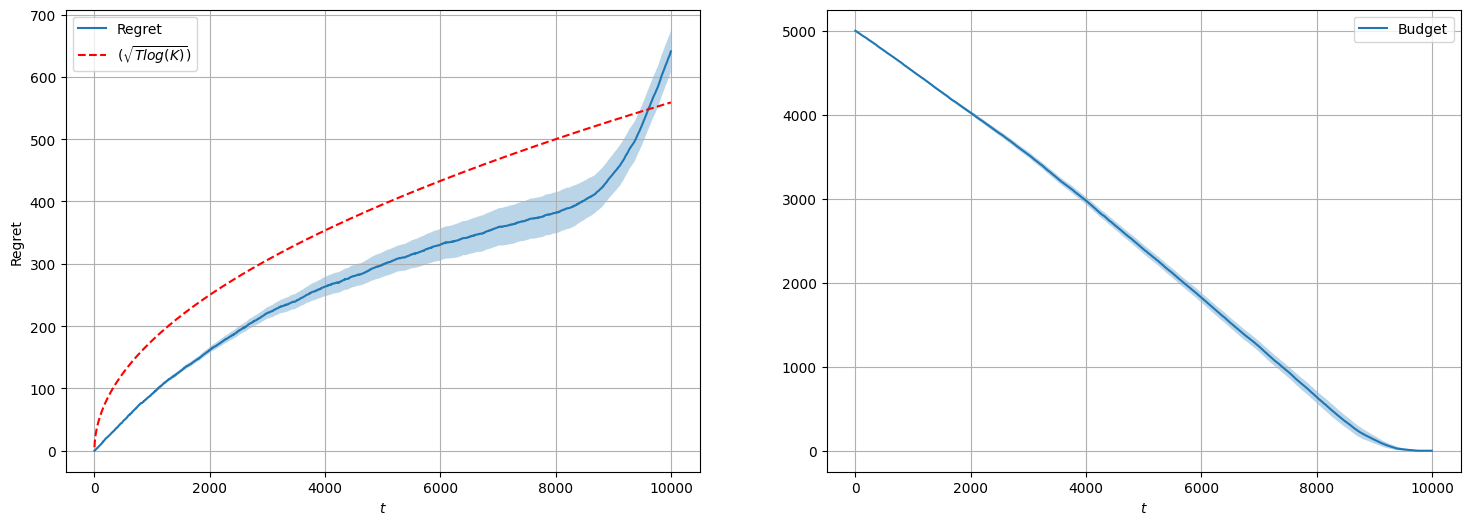

In [244]:
t = np.arange(1, T+1)
regret_theory = (500 / np.sqrt(8000*np.log(K))) * np.sqrt(t*np.log(K))

fig, axs = plt.subplots(1, 2, figsize = (18, 6))

# Regret plot
axs[0].plot(t, average_regret, label="Regret")
axs[0].fill_between(
    t,
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
)
axs[0].plot(t, regret_theory, label=r"$(\sqrt{Tlog(K)})$", linestyle='--', color='red')
axs[0].set_xlabel("$t$")
axs[0].set_ylabel("Regret")
axs[0].legend()
axs[0].grid(True)

# Budget plot
axs[1].plot(np.arange(T), average_budget, label="Budget")
axs[1].fill_between(
    np.arange(T),
    average_budget-budget_sd/np.sqrt(n_trials),
    average_budget+budget_sd/np.sqrt(n_trials),
    alpha=0.3,
)
axs[1].set_xlabel("$t$")
axs[1].legend()
axs[1].grid(True)

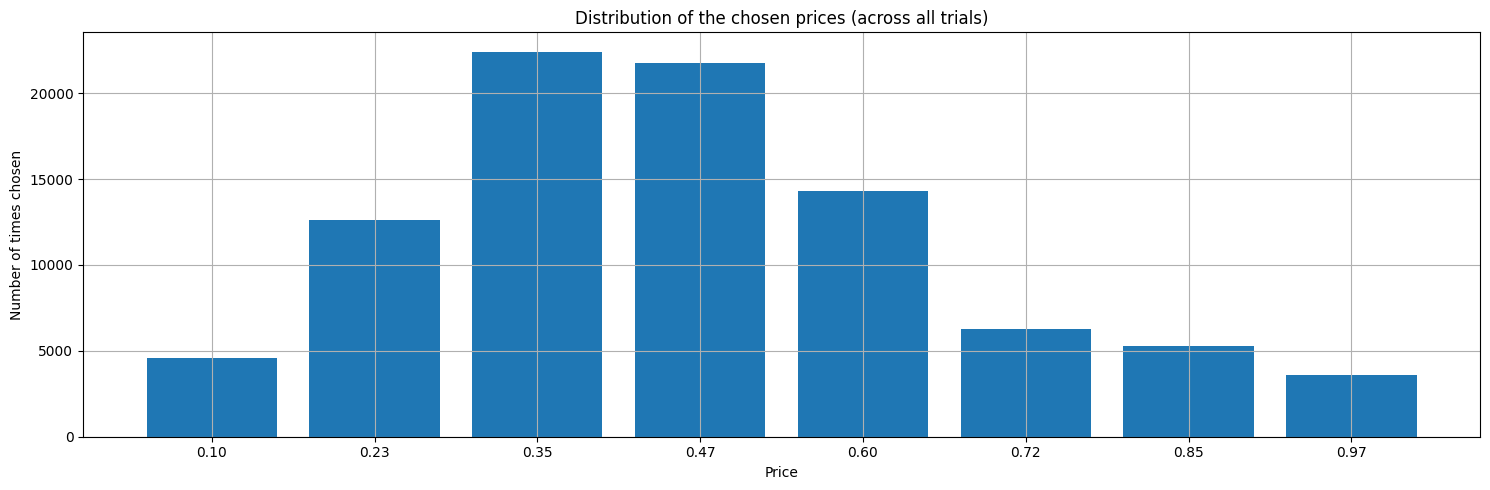

In [245]:
from collections import Counter

price_counts = Counter(prices_arr)
sorted_prices = sorted(price_counts)
counts = [price_counts[p] for p in sorted_prices]

plt.figure(figsize=(15, 5))
plt.bar([f"{p:.2f}" for p in sorted_prices], counts)
plt.xlabel("Price")
plt.ylabel("Number of times chosen")
plt.title("Distribution of the chosen prices (across all trials)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Execution - Stationary Environment

In [246]:
# Parameters
T = 10000
B = T * 40/100

# Prices
max_price = 1.1
price_step = 0.125
prices = np.arange(0.1, max_price, price_step)
K = len(prices)

learning_rate = np.sqrt(np.log(K)/(K*T))  # learning rate EXP3
eta=1/np.sqrt(T)   # learning rate Multiplicative pacing

In [247]:
distr = stats.norm(loc=0.5, scale=1)
valuation_distributions = []
for t in range(T):
  valuation_distributions.append(distr)

In [248]:
# Run clairvoyant
clairvoyant=WindowedClairvoyant(T, B, prices, valuation_distributions, window_size=50)
expected_clairvoyant_utilities = clairvoyant.run()

In [249]:
prices_arr = []
rewards = []
budget_per_trial =[]
regret_per_trial = []
n_trials = 10
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductHighlyNonStationaryEnvironment(T, valuation_distributions)
  multiplicative_pacing_agent = FFMultiplicativePacingAgent(prices, B, T, eta, learning_rate)
  count = 0
  agent_rewards = []
  budget=[]
  for t in range(T):
    if(count>=B):
      r_t = 0
      agent_rewards.append(r_t)
    else:
      # Get the actual price
      p_t = multiplicative_pacing_agent.pull_arm()
      # Get reward
      r_t = env.round(p_t)

      prices_arr.append(p_t)
      rewards.append(r_t)

      # Update agent state
      multiplicative_pacing_agent.update(r_t)

      agent_rewards.append(r_t)
      if(r_t > 0):
        count = count + 1
    budget.append(multiplicative_pacing_agent.get_budget())
  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)
  budget_per_trial.append(budget)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)
budget_per_trial = np.array(budget_per_trial)
average_budget = budget_per_trial.mean(axis=0)
budget_sd = budget_per_trial.std(axis=0)

### Results

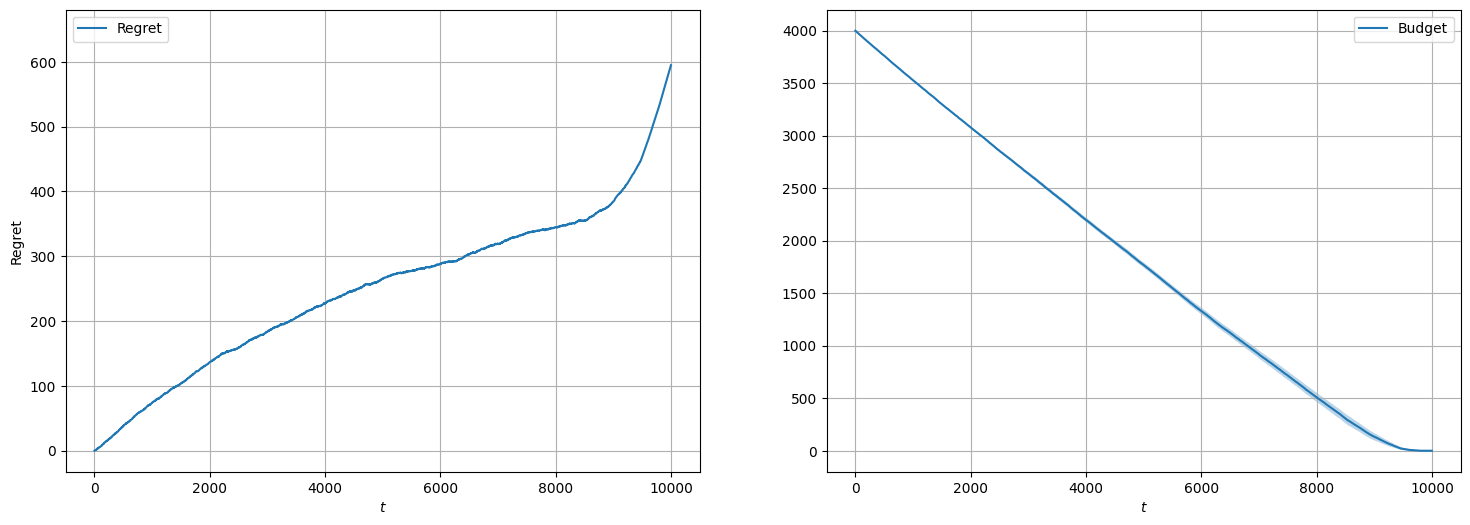

In [251]:
#avg pseudoregret vs theoretical regret
fig, axs = plt.subplots(1, 2, figsize = (18, 6))

# Regret plot
axs[0].plot(np.arange(T), average_regret, label="Regret")
axs[0].fill_between(
    t,
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
)

axs[0].set_xlabel("$t$")
axs[0].set_ylabel("Regret")
axs[0].legend()
axs[0].grid(True)

# Budget plot
axs[1].plot(np.arange(T), average_budget, label="Budget")
axs[1].fill_between(
    np.arange(T),
    average_budget-budget_sd/np.sqrt(n_trials),
    average_budget+budget_sd/np.sqrt(n_trials),
    alpha=0.3,
)
axs[1].set_xlabel("$t$")
axs[1].legend()
axs[1].grid(True)

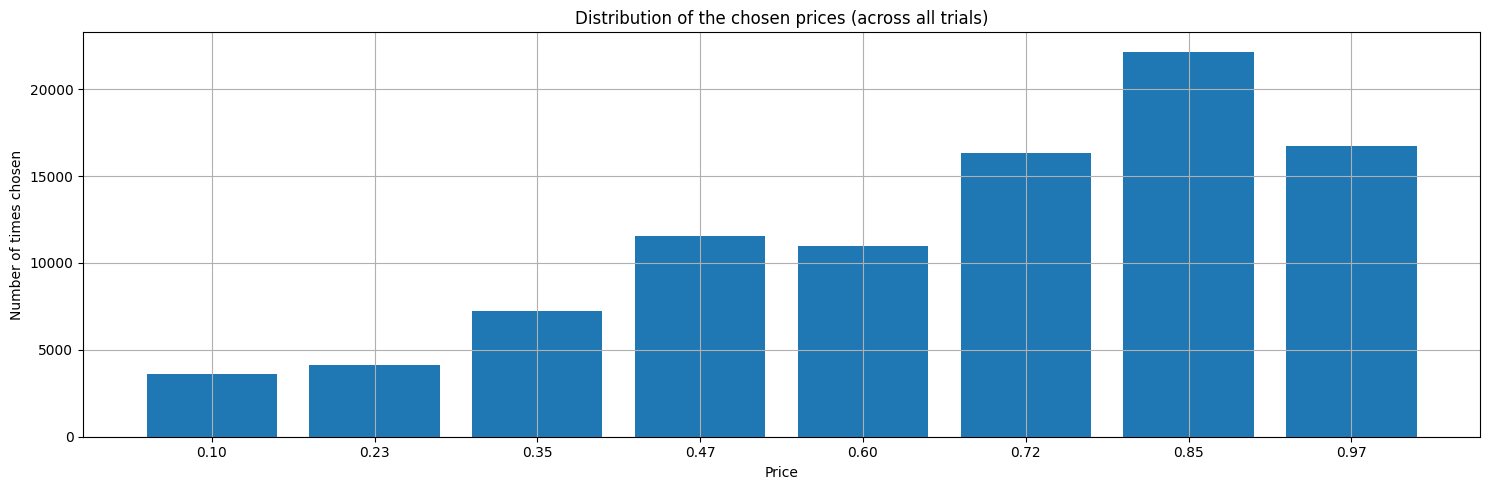

In [254]:
#chosen prices
from collections import Counter

price_counts = Counter(prices_arr)
sorted_prices = sorted(price_counts)
counts = [price_counts[p] for p in sorted_prices]

plt.figure(figsize=(15, 5))
plt.bar([f"{p:.2f}" for p in sorted_prices], counts)
plt.xlabel("Price")
plt.ylabel("Number of times chosen")
plt.title("Distribution of the chosen prices (across all trials)")
plt.grid(True)
plt.tight_layout()
plt.show()